In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('kc_house_data.csv')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [2]:
df.shape


(21613, 21)

In [3]:
duplicate_count = df.duplicated(subset=['id']).sum()
print(duplicate_count)

177


In [4]:
df = df.drop_duplicates('id')
df.shape

(21436, 21)

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
df = df.drop(labels='date', axis=1)
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [7]:
columns_reordered = [col for col in df.columns if col != 'price'] + ['price']
df = df[columns_reordered]

In [8]:
df.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

<Axes: xlabel='price', ylabel='Count'>

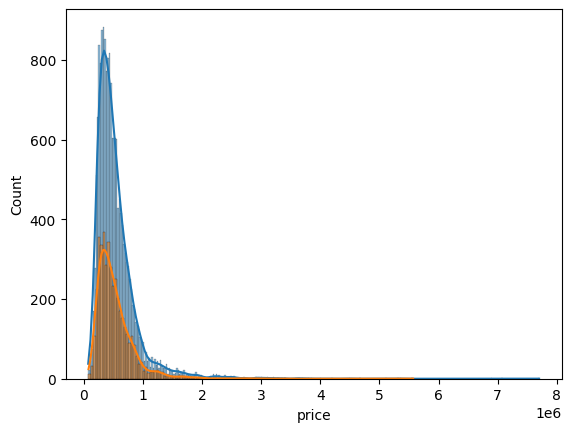

In [11]:
import seaborn as sns
sns.histplot(train_df['price'], kde=True)
sns.histplot(test_df['price'], kde=True)

In [12]:

# train_df, test_df = train_test_split(
#     df,
#     test_size=0.2,
#     random_state=42
# )

# train_df.to_csv('train.csv', index=False)
# test_df.to_csv('test.csv', index=False)

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

class TestNet(nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output):
        super().__init__()
        self.fc1 = nn.Linear(input_nodes, hidden_nodes)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_nodes, hidden_nodes)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_nodes, output)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze(-1)
    
class CustomDataset(Dataset): 
    def __init__(self, data_path):
        data = pd.read_csv(data_path)
        X = data.iloc[:, :-1].values.astype(float)
        y = data.iloc[:, -1].values.astype(float)

        # Compute per-feature min/max on X, and global min/max on y
        self.x_min = X.min(axis=0)
        self.x_max = X.max(axis=0)
        self.y_min = y.min()
        self.y_max = y.max()

        # Apply minmax scaling
        self.x = (X - self.x_min) / (self.x_max - self.x_min)
        self.y = (y - self.y_min) / (self.y_max - self.y_min)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        xi = torch.tensor(self.x[idx], dtype=torch.float32)
        yi = torch.tensor(self.y[idx], dtype=torch.float32)
        return xi, yi
    
    def reverse_transform(self, x_scaled, y_scaled):
        if isinstance(x_scaled, torch.Tensor):
            x_np = x_scaled.detach().cpu().numpy()
        else:
            x_np = x_scaled

        if isinstance(y_scaled, torch.Tensor):
            y_np = y_scaled.detach().cpu().numpy()
        else:
            y_np = y_scaled

        x_orig = x_np * (self.x_max - self.x_min) + self.x_min
        y_orig = y_np * (self.y_max - self.y_min) + self.y_min
        
        return torch.tensor(x_orig), torch.tensor(y_orig)


def train_net(model, train_dataloader, test_dataloader, optimizer, criterion, device, epochs, writer):
    model.to(device)
    model.train()

    train_epoch_losses = []
    val_epoch_losses = []
    for epoch in range(epochs):
        total_loss = 0

        for batch in train_dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # foward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        train_epoch_losses.append(avg_loss)

        # writer.add_scalar(tag='train_loss', scalar_value=avg_loss, global_step=epoch)

        val_losses = []
        model.eval()
        best_loss = np.inf
        with torch.no_grad():
            total_val_loss = 0
            for batch in test_dataloader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_losses.append(loss.item())

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    torch.save(model.state_dict(), 'best_model.pth')

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_val_loss:.4f}")
        val_epoch_losses.append(avg_val_loss)

        # writer.add_scalar(tag='Loss/train', scale_value=avg_loss, global_step=epoch)
        # writer.add_scalar(tag='Loss/validation', scale_value=avg_val_loss, global_step=epoch)   
        writer.add_scalars('Loss', {'tain': avg_loss, 'val': avg_val_loss}, epoch)
        for name, param in model.named_parameters():
            writer.add_histogram(f'Prameters/{name}', param, epoch)
            writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_epoch_losses, 'b-', label='Training Loss')  # Blue solid line
    plt.plot(range(epochs), val_epoch_losses, 'r--', label='Validation Loss') # Red dashed line 
    plt.legend()


def test_net(model, test_dataset, test_dataloader, criterion, device):
    model.to(device)
    model.eval()

    total_loss1 = 0
    total_loss2 = 0
    with torch.no_grad():
        batch_num = 0
        for batch in test_dataloader:
            batch_num += 1
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pss
            outputs = model(inputs)
            loss2 = criterion(outputs, targets)

            _, targets = test_dataset.reverse_transform(inputs, targets)
            _, outputs = test_dataset.reverse_transform(inputs, outputs)

            loss1 = torch.abs(outputs - targets)

            total_loss1 += loss1.mean().item()
            total_loss2 += loss2.item()

            print(f"Batch: [{batch_num}/{len(test_dataloader)}], Loss1: {loss1.mean().item():.4f}")
            print(f"Batch: [{batch_num}/{len(test_dataloader)}], Loss2: {loss2.item():.4f}")

        avg_loss1 = total_loss1 / len(test_dataloader)
        avg_loss2 = total_loss2 / len(test_dataloader)
        print(f"Loss: {avg_loss1:.4f}")
        print(f"Loss: {avg_loss2:.4f}")


In [14]:
train_dataset = CustomDataset('train.csv')
test_dataset = CustomDataset('test.csv')
num_workers = 0

batch_size = 256

lr = 1e-5

model = TestNet(19, 16, 1)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)   
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.MSELoss()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

epochs = 100

cuda:0


Epoch [1/100], Loss: 0.0156
Epoch [1/100], Loss: 0.0112
Epoch [2/100], Loss: 0.0141
Epoch [2/100], Loss: 0.0102
Epoch [3/100], Loss: 0.0128
Epoch [3/100], Loss: 0.0093
Epoch [4/100], Loss: 0.0115
Epoch [4/100], Loss: 0.0085
Epoch [5/100], Loss: 0.0105
Epoch [5/100], Loss: 0.0079
Epoch [6/100], Loss: 0.0095
Epoch [6/100], Loss: 0.0072
Epoch [7/100], Loss: 0.0086
Epoch [7/100], Loss: 0.0067
Epoch [8/100], Loss: 0.0078
Epoch [8/100], Loss: 0.0062
Epoch [9/100], Loss: 0.0071
Epoch [9/100], Loss: 0.0058
Epoch [10/100], Loss: 0.0065
Epoch [10/100], Loss: 0.0055
Epoch [11/100], Loss: 0.0060
Epoch [11/100], Loss: 0.0052
Epoch [12/100], Loss: 0.0055
Epoch [12/100], Loss: 0.0050
Epoch [13/100], Loss: 0.0051
Epoch [13/100], Loss: 0.0047
Epoch [14/100], Loss: 0.0047
Epoch [14/100], Loss: 0.0046
Epoch [15/100], Loss: 0.0043
Epoch [15/100], Loss: 0.0044
Epoch [16/100], Loss: 0.0041
Epoch [16/100], Loss: 0.0043
Epoch [17/100], Loss: 0.0038
Epoch [17/100], Loss: 0.0042
Epoch [18/100], Loss: 0.0036
Epo

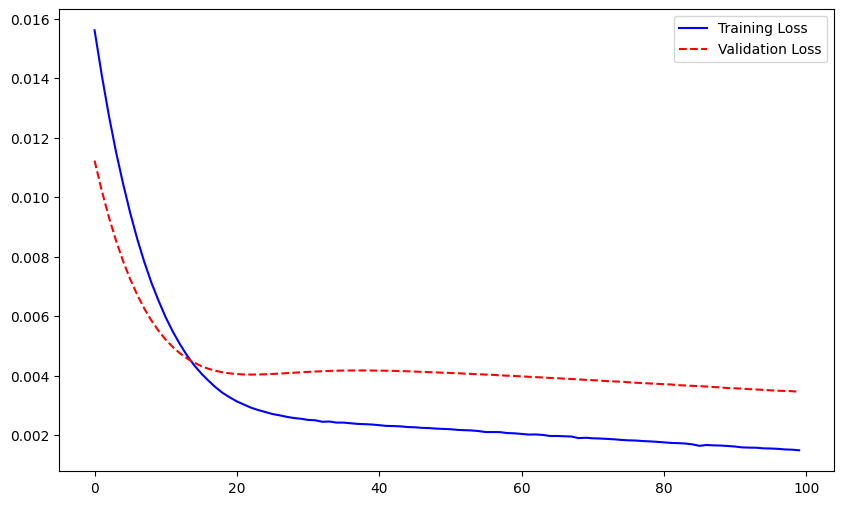

In [15]:
writer = SummaryWriter(log_dir='./log/')
train_net(model, train_dataloader, test_dataloader, optimizer, criterion, device, epochs, writer)

writer.close()

In [16]:
state_dict = torch.load('best_model.pth')
model.load_state_dict(state_dict)
test_net(model, test_dataset, test_dataloader, criterion, device)

Batch: [1/16], Loss1: 192060.5790
Batch: [1/16], Loss2: 0.0030
Batch: [2/16], Loss1: 192782.7559
Batch: [2/16], Loss2: 0.0037
Batch: [3/16], Loss1: 184233.2888
Batch: [3/16], Loss2: 0.0027
Batch: [4/16], Loss1: 192065.6229
Batch: [4/16], Loss2: 0.0041
Batch: [5/16], Loss1: 177334.7018
Batch: [5/16], Loss2: 0.0029
Batch: [6/16], Loss1: 191220.2519
Batch: [6/16], Loss2: 0.0032
Batch: [7/16], Loss1: 209002.1974
Batch: [7/16], Loss2: 0.0048
Batch: [8/16], Loss1: 158895.9742
Batch: [8/16], Loss2: 0.0024
Batch: [9/16], Loss1: 163621.8050
Batch: [9/16], Loss2: 0.0021
Batch: [10/16], Loss1: 192294.9835
Batch: [10/16], Loss2: 0.0037
Batch: [11/16], Loss1: 215033.0530
Batch: [11/16], Loss2: 0.0071
Batch: [12/16], Loss1: 190664.1613
Batch: [12/16], Loss2: 0.0042
Batch: [13/16], Loss1: 202394.6717
Batch: [13/16], Loss2: 0.0032
Batch: [14/16], Loss1: 195135.0493
Batch: [14/16], Loss2: 0.0031
Batch: [15/16], Loss1: 177923.7434
Batch: [15/16], Loss2: 0.0027
Batch: [16/16], Loss1: 170358.8564
Batch: [

In [17]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [18]:
train_set = set(train_df)
test_set = set(test_df)

In [19]:
train_set

{'bathrooms',
 'bedrooms',
 'condition',
 'floors',
 'grade',
 'id',
 'lat',
 'long',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'zipcode'}

In [20]:
test_set

{'bathrooms',
 'bedrooms',
 'condition',
 'floors',
 'grade',
 'id',
 'lat',
 'long',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'zipcode'}

In [21]:
train_ids = set(train_df['id'])
test_ids = set(test_df['id'])

In [22]:
train_ids

{1777500160,
 1424130050,
 2608300035,
 597000195,
 9545220100,
 711000070,
 3216900100,
 2013200390,
 7129301001,
 4136960010,
 7625703435,
 9834201100,
 4302700559,
 8562901010,
 5253300243,
 7935000595,
 5100404761,
 8731951130,
 7203160090,
 3336002215,
 7227801630,
 8819900449,
 7224000545,
 7278100515,
 4457300005,
 7950303270,
 7749500970,
 5006000170,
 711000110,
 7935000625,
 1024000050,
 2212200500,
 9376301110,
 9376301111,
 9376301112,
 9834201145,
 6752600130,
 7202340930,
 452001860,
 3764650050,
 2608300103,
 8901001290,
 1999700045,
 1565950030,
 3026059341,
 3211100240,
 9485910100,
 5710610520,
 993001563,
 7202340960,
 3026059361,
 452001890,
 3026059362,
 1024000100,
 5253300320,
 1180500070,
 8651440230,
 7283900521,
 7852130410,
 8562901100,
 1024000109,
 5315100784,
 6300500081,
 7237501040,
 9834201205,
 8901001335,
 3585900665,
 8651440250,
 7852130430,
 6885900415,
 1592000640,
 8649900160,
 8562770050,
 1180500100,
 5315100805,
 5315100806,
 7283900551,
 6300

In [23]:
common_ids = train_ids & test_ids
print(f"训练集和测试集共有的样本数量: {len(common_ids)}")

训练集和测试集共有的样本数量: 0


In [24]:
# 检查训练集内是否有重复样本
train_duplicates = train_df.duplicated(subset=['id']).sum()
print(f"训练集中重复的样本数: {train_duplicates}")

# 检查测试集内是否有重复样本
test_duplicates = test_df.duplicated(subset=['id']).sum()
print(f"测试集中重复的样本数: {test_duplicates}")

训练集中重复的样本数: 0
测试集中重复的样本数: 0


In [25]:
import seaborn as sns

print(train_df['price'].describe())
print(test_df['price'].describe())

count    1.714800e+04
mean     5.427105e+05
std      3.733802e+05
min      7.500000e+04
25%      3.248750e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64
count    4.288000e+03
mean     5.318066e+05
std      3.438947e+05
min      8.000000e+04
25%      3.198375e+05
50%      4.500000e+05
75%      6.430000e+05
max      5.570000e+06
Name: price, dtype: float64


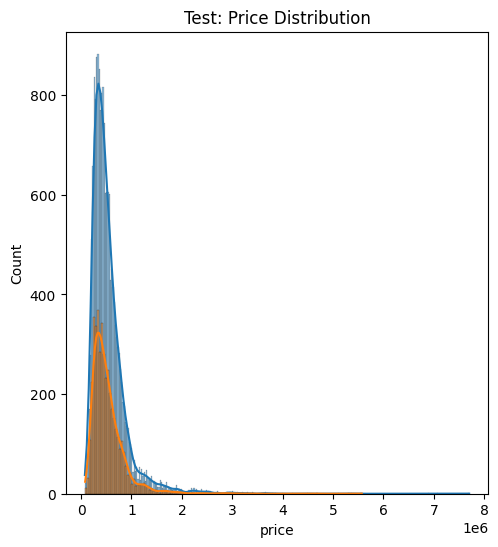

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.histplot(train_df['price'], kde=True)
plt.title('Train: Price Distribution')

# plt.subplot(1, 2, 2)
sns.histplot(test_df['price'], kde=True)
plt.title('Test: Price Distribution')
plt.show()